# **1. Perkenalan Dataset**

Dataset yang digunakan: **Diabetes Prediction Dataset**
- Sumber: Healthcare/Medical Data
- Jumlah sampel: Variable (depends on dataset size)
- Jumlah fitur: 8 (gender, age, hypertension, heart_disease, smoking_history, bmi, HbA1c_level, blood_glucose_level)
- Target: diabetes (0 = No Diabetes, 1 = Diabetes)
- Tipe data: Mixed (numerik untuk sebagian besar fitur, kategorikal untuk gender dan smoking_history)

# **2. Import Library**

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


# **3. Memuat Dataset**

In [2]:
# Load Diabetes dataset
df = pd.read_csv('diabetes_prediction_dataset.csv')

# Define feature categories
categorical_features = ['gender', 'smoking_history']
numerical_features = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']
target_column = 'diabetes'

# Save raw data
df.to_csv('diabetes_raw.csv', index=False)

print(f"Dataset shape: {df.shape}")
print(f"\nDataset columns: {list(df.columns)}")
print(f"\nDataset info:")
print(df.info())
print(f"\nFirst 5 rows:")
df.head()

Dataset shape: (100000, 9)

Dataset columns: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None

First 5 rows:


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


# **4. Exploratory Data Analysis (EDA)**

In [3]:
# Basic statistics
print("=== BASIC STATISTICS ===")
print("\nNumerical Features:")
print(df[numerical_features].describe())

print("\n=== MISSING VALUES ===")
missing_values = df.isnull().sum()
print(missing_values)
print(f"Total missing values: {missing_values.sum()}")

print("\n=== TARGET DISTRIBUTION ===")
target_dist = df[target_column].value_counts()
print(target_dist)
print(f"Diabetes prevalence: {target_dist[1]/len(df)*100:.2f}%")

print("\n=== CATEGORICAL FEATURES DISTRIBUTION ===")
for col in categorical_features:
    print(f"\n{col}:")
    print(df[col].value_counts())

=== BASIC STATISTICS ===

Numerical Features:
                 age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840       0.26315       0.194593       6.636783   
min         0.080000       0.00000       0.000000      10.010000   
25%        24.000000       0.00000       0.000000      23.630000   
50%        43.000000       0.00000       0.000000      27.320000   
75%        60.000000       0.00000       0.000000      29.580000   
max        80.000000       1.00000       1.000000      95.690000   

         HbA1c_level  blood_glucose_level  
count  100000.000000        100000.000000  
mean        5.527507           138.058060  
std         1.070672            40.708136  
min         3.500000            80.000000  
25%         4.800000           100.000000  
50%         5.800000           140.000000  
75%         6.200000           15

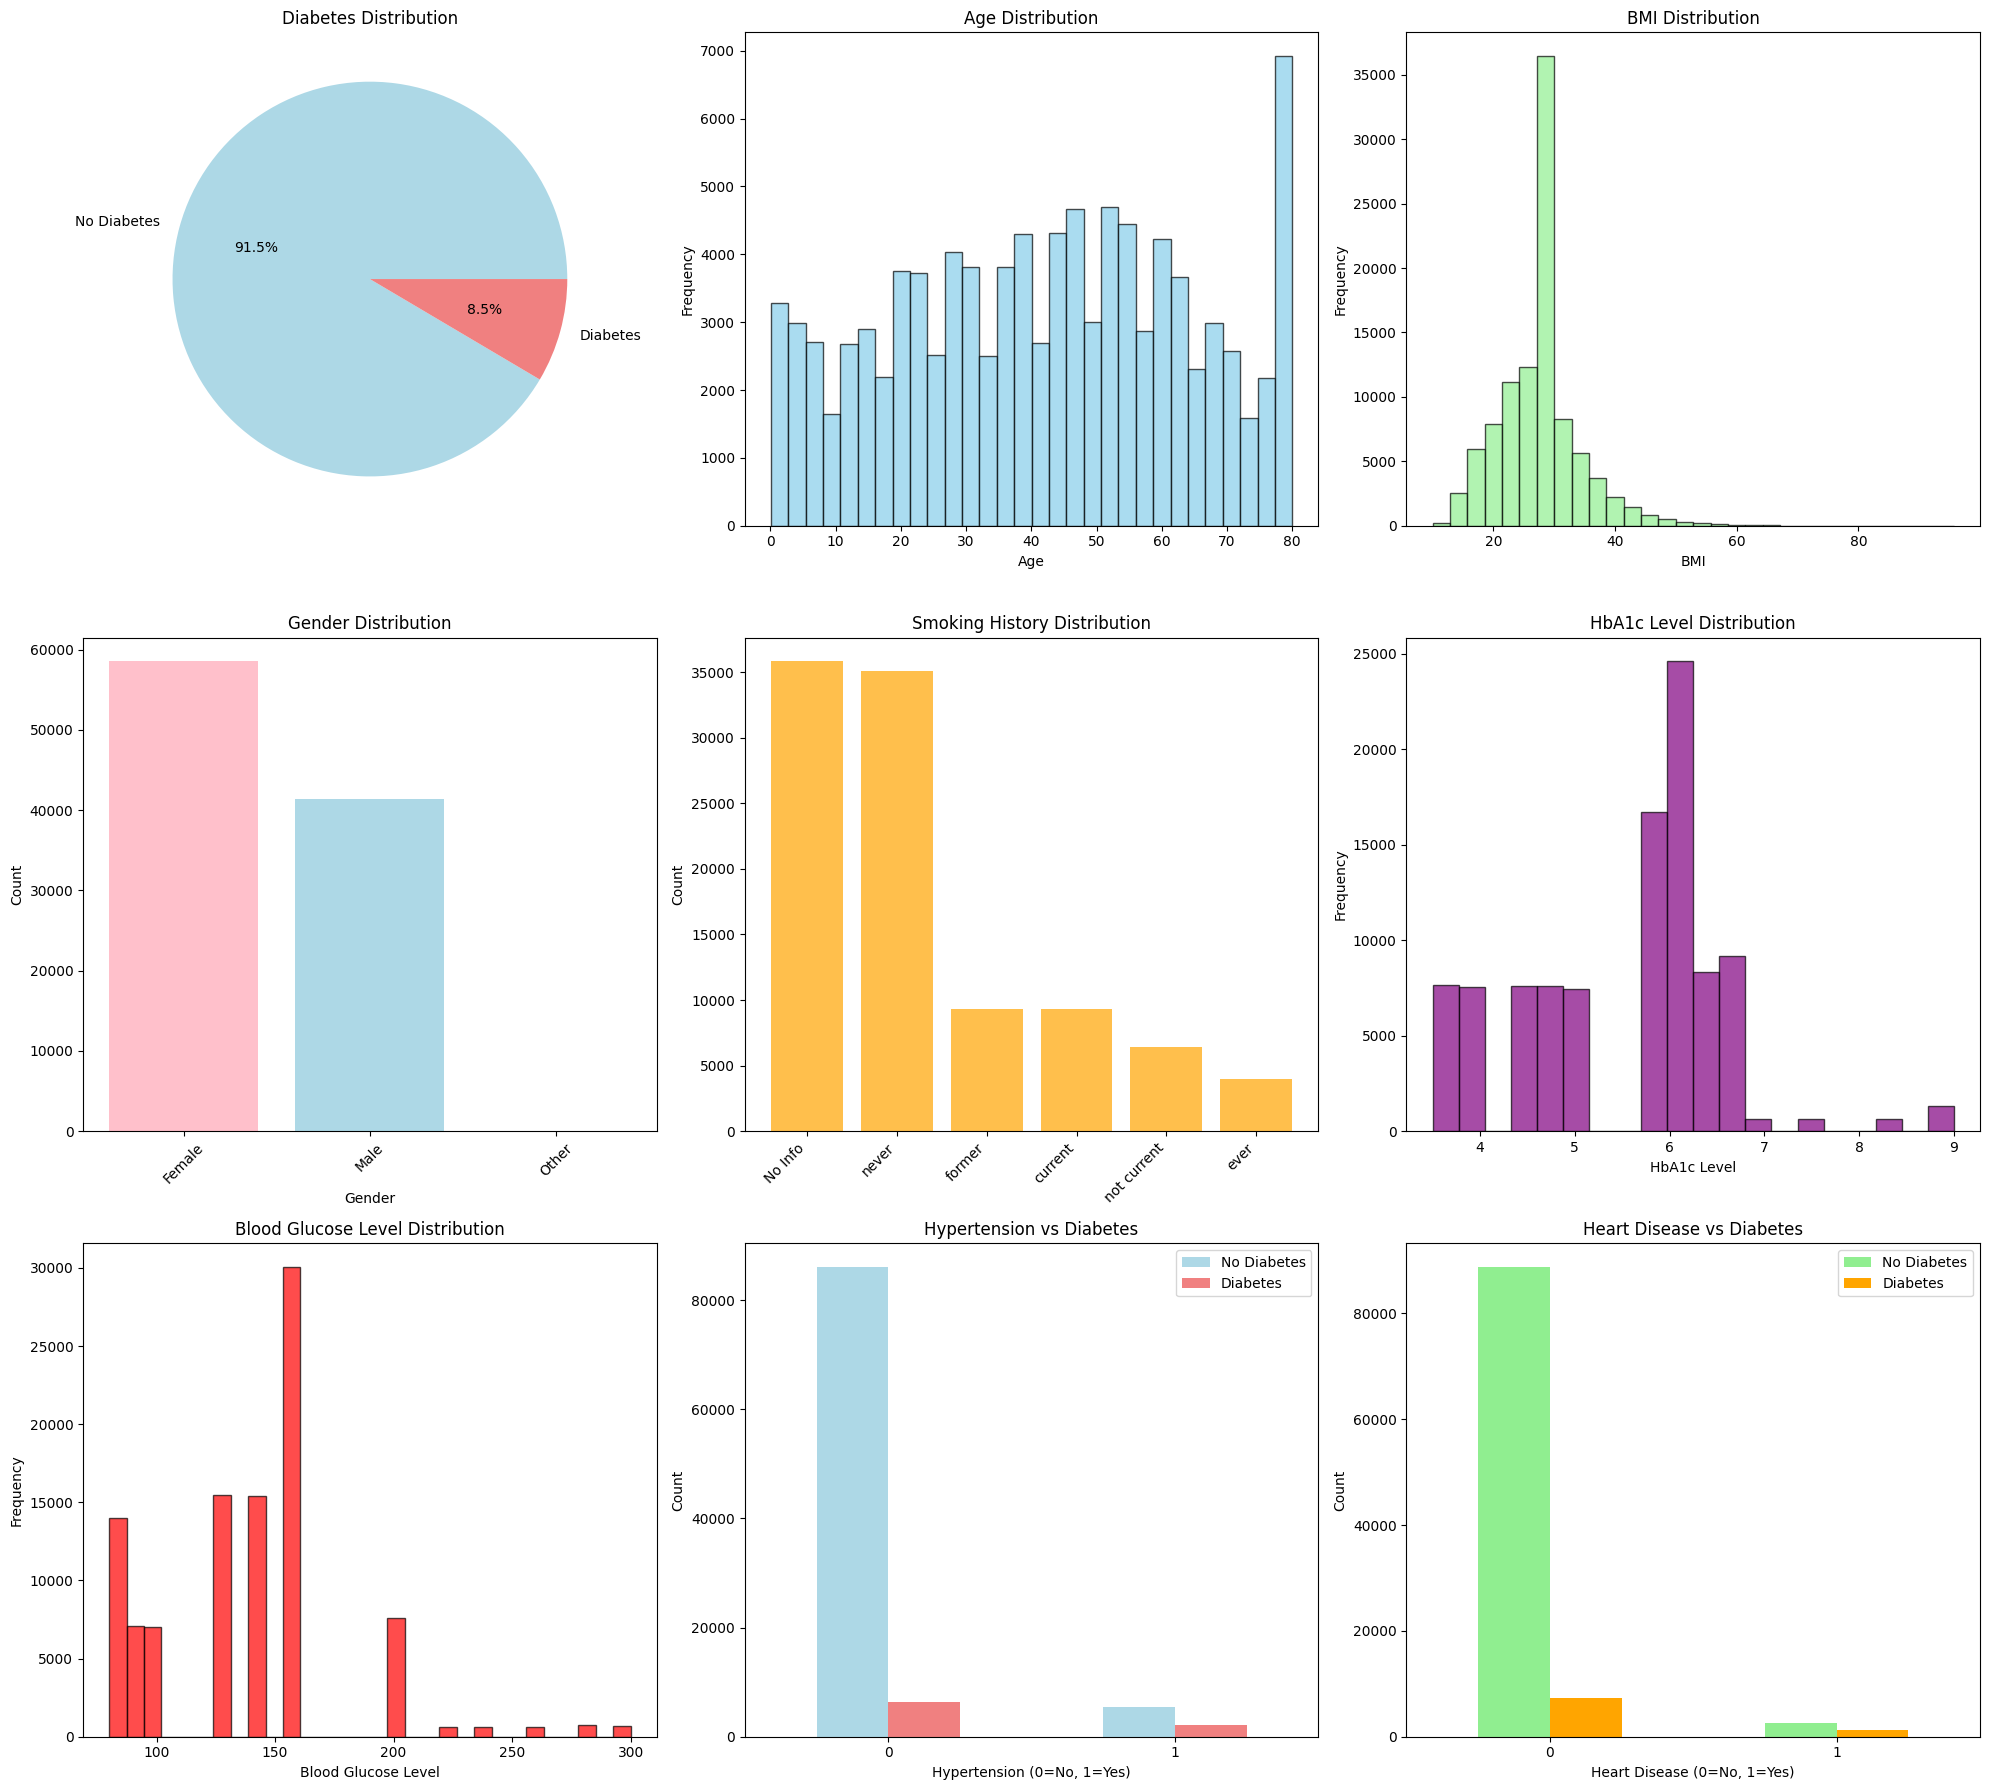

In [4]:
# Comprehensive visualizations
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
axes = axes.flatten()

# 1. Target distribution
target_counts = df[target_column].value_counts()
axes[0].pie(target_counts.values, labels=['No Diabetes', 'Diabetes'], autopct='%1.1f%%', 
           colors=['lightblue', 'lightcoral'])
axes[0].set_title('Diabetes Distribution')

# 2. Age distribution
axes[1].hist(df['age'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[1].set_title('Age Distribution')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Frequency')

# 3. BMI distribution
axes[2].hist(df['bmi'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[2].set_title('BMI Distribution')
axes[2].set_xlabel('BMI')
axes[2].set_ylabel('Frequency')

# 4. Gender distribution
gender_counts = df['gender'].value_counts()
axes[3].bar(gender_counts.index, gender_counts.values, color=['pink', 'lightblue'])
axes[3].set_title('Gender Distribution')
axes[3].set_xlabel('Gender')
axes[3].set_ylabel('Count')
axes[3].tick_params(axis='x', rotation=45)

# 5. Smoking history distribution
smoking_counts = df['smoking_history'].value_counts()
axes[4].bar(range(len(smoking_counts)), smoking_counts.values, color='orange', alpha=0.7)
axes[4].set_xticks(range(len(smoking_counts)))
axes[4].set_xticklabels(smoking_counts.index, rotation=45, ha='right')
axes[4].set_title('Smoking History Distribution')
axes[4].set_ylabel('Count')

# 6. HbA1c levels
axes[5].hist(df['HbA1c_level'], bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[5].set_title('HbA1c Level Distribution')
axes[5].set_xlabel('HbA1c Level')
axes[5].set_ylabel('Frequency')

# 7. Blood glucose levels
axes[6].hist(df['blood_glucose_level'], bins=30, alpha=0.7, color='red', edgecolor='black')
axes[6].set_title('Blood Glucose Level Distribution')
axes[6].set_xlabel('Blood Glucose Level')
axes[6].set_ylabel('Frequency')

# 8. Hypertension vs Diabetes
hyp_diabetes = pd.crosstab(df['hypertension'], df[target_column])
hyp_diabetes.plot(kind='bar', ax=axes[7], color=['lightblue', 'lightcoral'])
axes[7].set_title('Hypertension vs Diabetes')
axes[7].set_xlabel('Hypertension (0=No, 1=Yes)')
axes[7].set_ylabel('Count')
axes[7].legend(['No Diabetes', 'Diabetes'])
axes[7].tick_params(axis='x', rotation=0)

# 9. Heart disease vs Diabetes
heart_diabetes = pd.crosstab(df['heart_disease'], df[target_column])
heart_diabetes.plot(kind='bar', ax=axes[8], color=['lightgreen', 'orange'])
axes[8].set_title('Heart Disease vs Diabetes')
axes[8].set_xlabel('Heart Disease (0=No, 1=Yes)')
axes[8].set_ylabel('Count')
axes[8].legend(['No Diabetes', 'Diabetes'])
axes[8].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

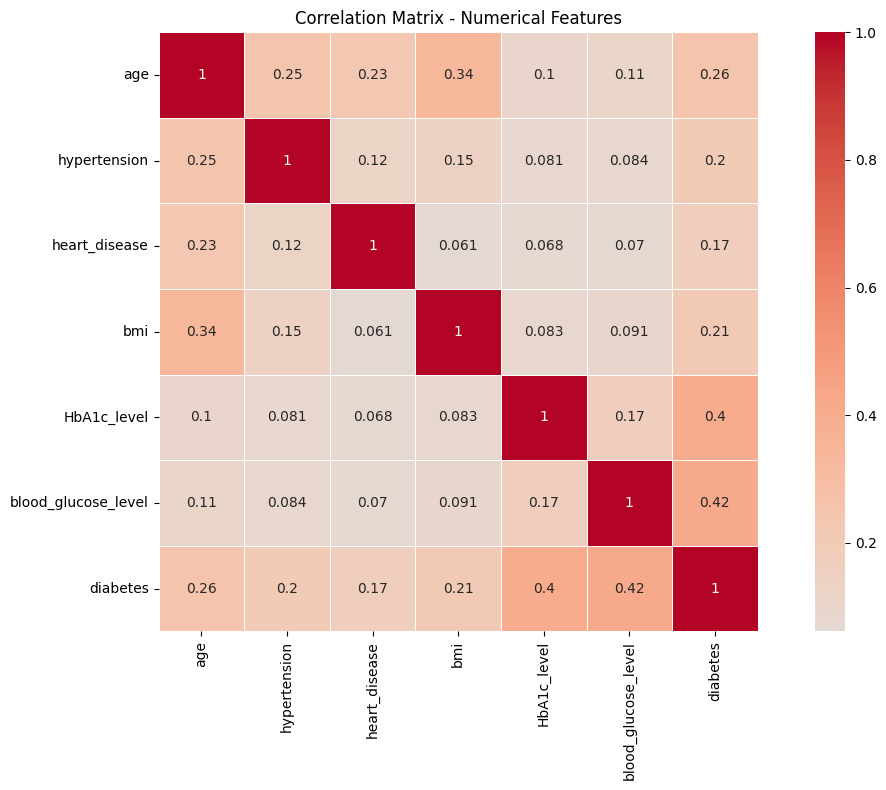

In [5]:
# Correlation analysis
plt.figure(figsize=(12, 8))
all_numerical = numerical_features + [target_column]
correlation_matrix = df[all_numerical].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
           square=True, linewidths=0.5)
plt.title('Correlation Matrix - Numerical Features')
plt.tight_layout()
plt.show()

In [6]:
# Feature analysis by diabetes status
print("=== FEATURE STATISTICS BY DIABETES STATUS ===")
for feature in numerical_features:
    print(f"\n{feature.upper()}:")
    no_diabetes = df[df[target_column] == 0][feature]
    diabetes = df[df[target_column] == 1][feature]
    
    print(f"No Diabetes - Mean: {no_diabetes.mean():.2f}, Std: {no_diabetes.std():.2f}")
    print(f"Diabetes - Mean: {diabetes.mean():.2f}, Std: {diabetes.std():.2f}")
    print(f"Difference: {diabetes.mean() - no_diabetes.mean():.2f}")

=== FEATURE STATISTICS BY DIABETES STATUS ===

AGE:
No Diabetes - Mean: 40.12, Std: 22.31
Diabetes - Mean: 60.95, Std: 14.55
Difference: 20.83

HYPERTENSION:
No Diabetes - Mean: 0.06, Std: 0.24
Diabetes - Mean: 0.25, Std: 0.43
Difference: 0.19

HEART_DISEASE:
No Diabetes - Mean: 0.03, Std: 0.17
Diabetes - Mean: 0.15, Std: 0.36
Difference: 0.12

BMI:
No Diabetes - Mean: 26.89, Std: 6.37
Diabetes - Mean: 31.99, Std: 7.56
Difference: 5.10

HBA1C_LEVEL:
No Diabetes - Mean: 5.40, Std: 0.97
Diabetes - Mean: 6.93, Std: 1.08
Difference: 1.54

BLOOD_GLUCOSE_LEVEL:
No Diabetes - Mean: 132.85, Std: 34.25
Diabetes - Mean: 194.09, Std: 58.64
Difference: 61.24


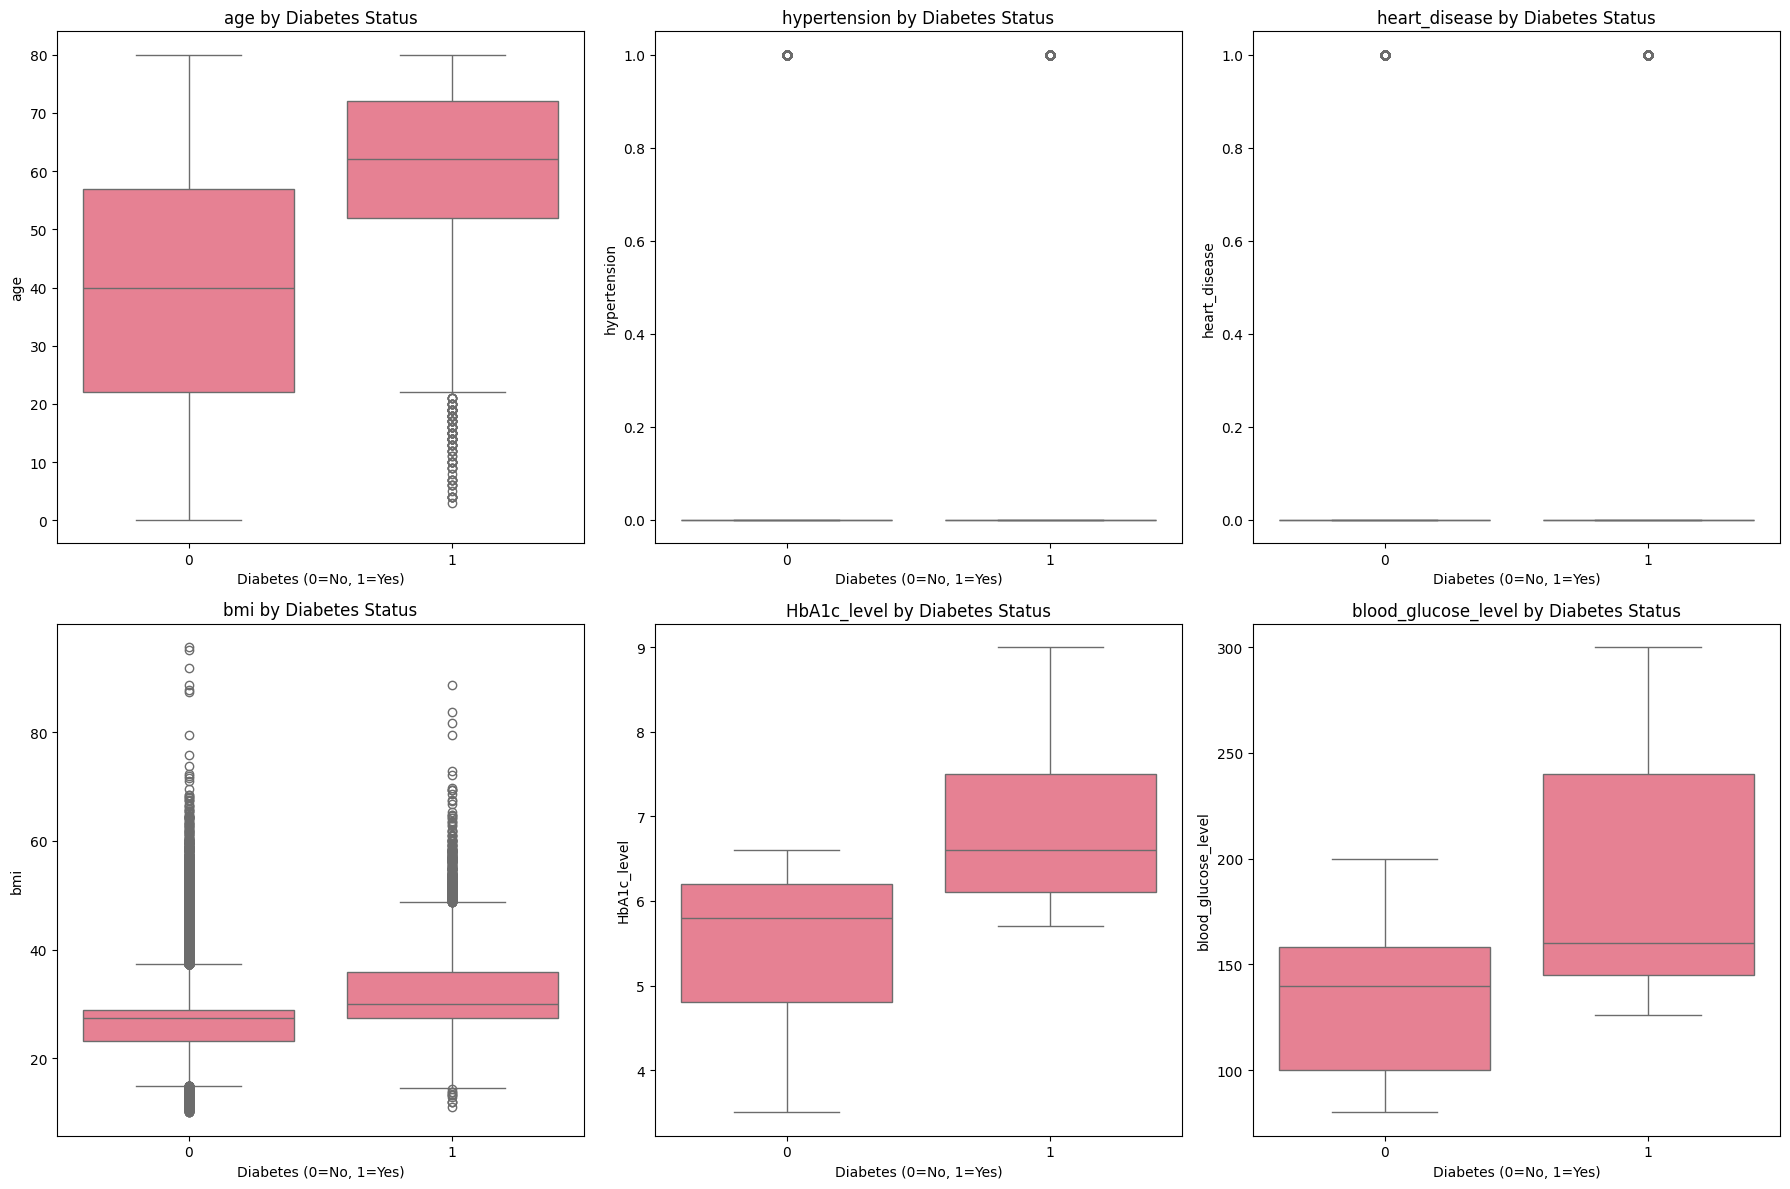

In [7]:
# Box plots for numerical features by diabetes status
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(data=df, x=target_column, y=feature, ax=axes[i])
    axes[i].set_title(f'{feature} by Diabetes Status')
    axes[i].set_xlabel('Diabetes (0=No, 1=Yes)')

plt.tight_layout()
plt.show()

# **5. Data Preprocessing**

In [8]:
print("=== DATA PREPROCESSING STEPS ===")

# 1. Check for missing values
print("\n1. Checking for missing values:")
missing_values = df.isnull().sum()
print(missing_values)
print(f"Total missing values: {missing_values.sum()}")

# Handle missing values if any
df_clean = df.copy()
if missing_values.sum() > 0:
    print("Handling missing values...")
    # Fill numerical missing values with median
    for col in numerical_features:
        if df_clean[col].isnull().sum() > 0:
            median_val = df_clean[col].median()
            df_clean[col].fillna(median_val, inplace=True)
            print(f"  - Filled {col} with median: {median_val:.2f}")
    
    # Fill categorical missing values with mode
    for col in categorical_features:
        if df_clean[col].isnull().sum() > 0:
            mode_val = df_clean[col].mode()[0]
            df_clean[col].fillna(mode_val, inplace=True)
            print(f"  - Filled {col} with mode: {mode_val}")
else:
    print("No missing values found.")

# 2. Check for duplicates
print("\n2. Checking for duplicates:")
duplicates = df_clean.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

if duplicates > 0:
    print("Removing duplicates...")
    df_clean = df_clean.drop_duplicates().reset_index(drop=True)
    print(f"Shape after removing duplicates: {df_clean.shape}")
else:
    print("No duplicates found.")

=== DATA PREPROCESSING STEPS ===

1. Checking for missing values:
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64
Total missing values: 0
No missing values found.

2. Checking for duplicates:
Number of duplicate rows: 3854
Removing duplicates...
Shape after removing duplicates: (96146, 9)


In [9]:
# 3. Data type cleaning and validation
print("\n3. Data type cleaning and validation:")

# Clean categorical features
for col in categorical_features:
    df_clean[col] = df_clean[col].astype(str).str.strip().str.lower()
    print(f"Cleaned {col}: {df_clean[col].unique()}")

# Validate numerical ranges
print("\nValidating numerical ranges:")
original_len = len(df_clean)

# Age validation (0-120)
if 'age' in df_clean.columns:
    df_clean = df_clean[(df_clean['age'] > 0) & (df_clean['age'] <= 120)]
    print(f"Age validation: {original_len} → {len(df_clean)} rows")

# BMI validation (10-70)
if 'bmi' in df_clean.columns:
    df_clean = df_clean[(df_clean['bmi'] > 0) & (df_clean['bmi'] <= 70)]
    print(f"BMI validation: kept rows with BMI > 0 and <= 70")

df_clean = df_clean.reset_index(drop=True)
print(f"Final shape after validation: {df_clean.shape}")


3. Data type cleaning and validation:
Cleaned gender: ['female' 'male' 'other']
Cleaned smoking_history: ['never' 'no info' 'current' 'former' 'ever' 'not current']

Validating numerical ranges:
Age validation: 96146 → 96146 rows
BMI validation: kept rows with BMI > 0 and <= 70
Final shape after validation: (96127, 9)


In [10]:
# 4. Outlier detection using IQR method
print("\n4. Outlier Detection using IQR method:")

def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers.index, lower_bound, upper_bound

outlier_summary = {}
for feature in numerical_features:
    outlier_indices, lower, upper = detect_outliers_iqr(df_clean, feature)
    outlier_count = len(outlier_indices)
    outlier_percentage = outlier_count/len(df_clean)*100
    
    outlier_summary[feature] = {
        'count': outlier_count,
        'percentage': outlier_percentage,
        'bounds': (lower, upper)
    }
    
    print(f"{feature}: {outlier_count} outliers ({outlier_percentage:.2f}%) - Bounds: [{lower:.2f}, {upper:.2f}]")

print("\nNote: Keeping outliers as they may be important for diabetes prediction.")


4. Outlier Detection using IQR method:
age: 0 outliers (0.00%) - Bounds: [-28.50, 111.50]
hypertension: 7460 outliers (7.76%) - Bounds: [0.00, 0.00]
heart_disease: 3923 outliers (4.08%) - Bounds: [0.00, 0.00]
bmi: 5358 outliers (5.57%) - Bounds: [13.72, 39.53]
HbA1c_level: 1312 outliers (1.36%) - Bounds: [2.70, 8.30]
blood_glucose_level: 2029 outliers (2.11%) - Bounds: [11.50, 247.50]

Note: Keeping outliers as they may be important for diabetes prediction.


In [11]:
# 5. Feature encoding
print("\n5. Feature Encoding:")

# Separate features and target
X = df_clean.drop(target_column, axis=1)
y = df_clean[target_column]

# Encode categorical features using Label Encoding
label_encoders = {}
X_encoded = X.copy()

for col in categorical_features:
    if col in X_encoded.columns:
        label_encoders[col] = LabelEncoder()
        X_encoded[col] = label_encoders[col].fit_transform(X_encoded[col])
        
        # Show encoding mapping
        mapping = dict(zip(label_encoders[col].classes_, 
                          label_encoders[col].transform(label_encoders[col].classes_)))
        print(f"Encoded {col}: {mapping}")

print(f"\nFeatures after encoding: {list(X_encoded.columns)}")


5. Feature Encoding:
Encoded gender: {'female': 0, 'male': 1, 'other': 2}
Encoded smoking_history: {'current': 0, 'ever': 1, 'former': 2, 'never': 3, 'no info': 4, 'not current': 5}

Features after encoding: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level']


In [12]:
# 6. Feature scaling
print("\n6. Feature Scaling:")

print(f"Original ranges for numerical features:")
for feature in numerical_features:
    if feature in X_encoded.columns:
        print(f"  {feature}: {X_encoded[feature].min():.2f} - {X_encoded[feature].max():.2f}")

# Apply StandardScaler to numerical features only
scaler = StandardScaler()
X_scaled = X_encoded.copy()

# Scale only numerical features
numerical_cols_to_scale = [col for col in numerical_features if col in X_scaled.columns]
X_scaled[numerical_cols_to_scale] = scaler.fit_transform(X_encoded[numerical_cols_to_scale])

print(f"\nAfter scaling - ranges for numerical features:")
for feature in numerical_cols_to_scale:
    print(f"  {feature}: {X_scaled[feature].min():.2f} - {X_scaled[feature].max():.2f}")

print(f"\nCategorical features (not scaled): {[col for col in categorical_features if col in X_scaled.columns]}")


6. Feature Scaling:
Original ranges for numerical features:
  age: 0.08 - 80.00
  hypertension: 0.00 - 1.00
  heart_disease: 0.00 - 1.00
  bmi: 10.01 - 69.66
  HbA1c_level: 3.50 - 9.00
  blood_glucose_level: 80.00 - 300.00

After scaling - ranges for numerical features:
  age: -1.86 - 1.70
  hypertension: -0.29 - 3.45
  heart_disease: -0.21 - 4.85
  bmi: -2.57 - 6.30
  HbA1c_level: -1.89 - 3.23
  blood_glucose_level: -1.42 - 3.96

Categorical features (not scaled): ['gender', 'smoking_history']


In [13]:
# 7. Create final preprocessed dataset
print("\n7. Creating Final Preprocessed Dataset:")

# Combine scaled features with target
processed_df = X_scaled.copy()
processed_df[target_column] = y

print(f"Final preprocessed dataset shape: {processed_df.shape}")
print(f"Features: {list(processed_df.columns[:-1])}")
print(f"Target column: {target_column}")

print(f"\nTarget distribution in preprocessed data:")
target_dist = processed_df[target_column].value_counts().sort_index()
print(target_dist)
print(f"Diabetes prevalence: {target_dist[1]/len(processed_df)*100:.2f}%")

print(f"\nFirst 5 rows of preprocessed data:")
print(processed_df.head())

# Save preprocessed data
processed_df.to_csv('diabetes_preprocessed.csv', index=False)
print("\nPreprocessed data saved as 'diabetes_preprocessed.csv'")

# Verification
verification_df = pd.read_csv('diabetes_preprocessed.csv')
print(f"Verification - loaded file shape: {verification_df.shape}")


7. Creating Final Preprocessed Dataset:
Final preprocessed dataset shape: (96127, 9)
Features: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level']
Target column: diabetes

Target distribution in preprocessed data:
diabetes
0    87651
1     8476
Name: count, dtype: int64
Diabetes prevalence: 8.82%

First 5 rows of preprocessed data:
   gender       age  hypertension  heart_disease  smoking_history       bmi  \
0       0  1.700736     -0.290060       4.848035                3 -0.315368   
1       0  0.543327     -0.290060      -0.206269                4  0.001364   
2       1 -0.614082     -0.290060      -0.206269                3  0.001364   
3       0 -0.257956     -0.290060      -0.206269                0 -0.574107   
4       1  1.522673      3.447558       4.848035                0 -1.066306   

   HbA1c_level  blood_glucose_level  diabetes  
0     0.994628             0.043615         0  
1     0.994628            -1.42